In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy import distance
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import censusgeocode as cg
from random import uniform
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

## Preparing data

In [319]:
with open("../data/yelp_dataset/yelp_academic_dataset_business21.json", "r") as f:
    yelp = pd.read_json(f, orient="records", lines=True)
with open("../data/yelp_dataset/yelp_academic_dataset_checkin.json", "r") as c:
    checkin = pd.read_json(c, orient="records", lines=True)

In [321]:
years = range(2011,2022)
def checkin_year(row,y):
    if str(y) in row['date']:
        return 1
    else:
        return 0
for y in years:
    #checkin.loc[:,'checkin_'+str(y)] = 0
    checkin['checkin_'+str(y)] = checkin.apply(lambda row: checkin_year(row,y), axis=1)

checkin.rename({'date':'checkin_date'},inplace=True,axis=1)
result = pd.merge(yelp, checkin, how = 'left', on=["business_id"])

philly = result[result.city=='Philadelphia']
philly.reset_index(drop=True,inplace=True)
philly = philly[(philly.latitude.notna()) & (philly.longitude.notna())]
center = (39.952,-75.164)
philly['distance'] = philly.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
philly['is_cbd'] = philly.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 
philly.drop(['address', 'state', 'city', 'hours','attributes'], axis=1, inplace=True)

for y in years[1:]:
    philly['close_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y-1)]==1 and x['checkin_%s'%(y)]==0) 
                else 0, axis=1) 
    philly['open_%s'%(y)] = \
        philly.apply(lambda x: 
                1 if (x['checkin_%s'%(y)]==1 and x['checkin_%s'%(y-1)]==0) 
                else 0, axis=1) 
                
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio
    
status = philly[['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]]
philly=philly[(status == 1).any(axis=1)]
philly.reset_index(inplace=True,drop=True)

def count(status, year, df):
    count = df[status+'_'+str(year)].value_counts()[1]
    count_cbd = df[df[status+'_'+str(year)]==1].is_cbd.value_counts()[1]
    ratio = count_cbd/count * 100
    return count, count_cbd,ratio

## Exploratory Data Analysis

### 1. Yelp data
(1) All businesses
(2) Food businesses

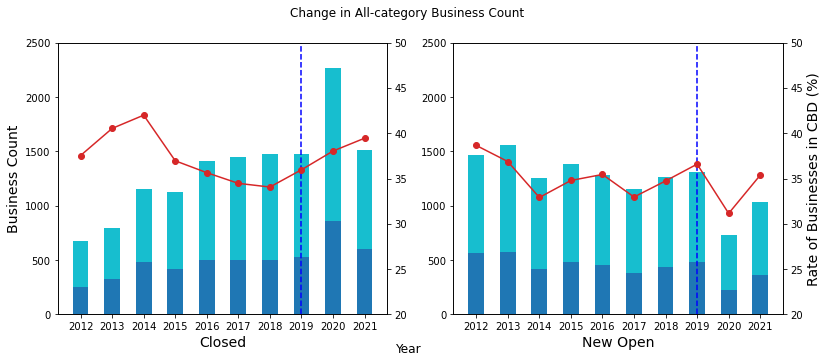

In [322]:
#(1)all businesses
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Closed",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2500)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,philly)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,philly)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New Open",fontsize=14)
#ax_o.set_ylabel("Opened Businesses Count",fontsize=14)
ax_o.set_ylim(0,2500)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,philly)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 2500, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2500, linestyles='--', color='b')

fig.suptitle(f'Change in All-category Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp.png")
plt.show()

### Match census tract from coordinates

In [101]:
locations = philly[['latitude','longitude']]
def geocode(row):
    index, lat, lng = row
    try:
        census = cg.coordinates(lng, lat)['2020 Census Blocks'][0]

        data = dict(geoid=census['GEOID'], 
                    state=census['STATE'], 
                    county=census['COUNTY'], 
                    tract=census['TRACT'], 
                    block=census['BLOCK'], 
                    lat=lat, 
                    lng=lng)

    except Exception as e:
        data = dict(lat=lat, 
                    lng=lng)

    return data

with ThreadPoolExecutor() as tpe:
     data = list(tqdm(tpe.map(geocode, locations.itertuples()), total=len(locations)))
df = pd.DataFrame.from_records(data)

  0%|          | 0/14569 [00:00<?, ?it/s]

In [104]:
# save for further use
df.to_csv('../output/yelp_census_tract.csv', index=False)

In [323]:
# join it with original data
use = df[['geoid', 'tract', 'block']]
philly_geo = philly.join(use)

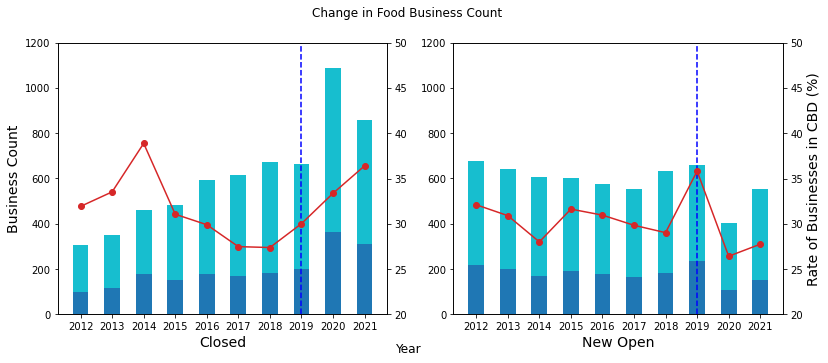

In [505]:
#(2) Food Businesses
food= philly_geo[philly_geo.categories.notna()][philly_geo[philly_geo.categories.notna()].categories.str.contains('food|restaurant|bar|cafe|Grocery', case=False)]
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(years[1:],[count('close', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax.bar(years[1:],[count('close', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax.set_xlabel("Closed",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,1200)
ax2=ax.twinx()
ax2.plot(years[1:],[count('close', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylim(20,50)
ax.set_xticks(years[1:], minor=False)
ax_o.bar(years[1:],[count('open', y,food)[0] for y in years[1:]],color="tab:cyan", width= 0.5 )
ax_o.bar(years[1:],[count('open', y,food)[1] for y in years[1:]],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New Open",fontsize=14)
ax_o.set_ylim(0,1200)
ax2=ax_o.twinx()
ax2.plot(years[1:],[count('open', y,food)[2] for y in years[1:]], color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(20,50)
ax_o.set_xticks(years[1:], minor=False)

ax.vlines(2019, 0, 1200, linestyles='--', color='b')
ax_o.vlines(2019, 0, 1200, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count ')
fig.supxlabel('Year')
plt.savefig("../output/yelp_food.png")
plt.show()

### 2.Business licenses data

In [6]:
shape_map_path = r"../data/business_licenses/business_licenses.shp"
shape_map = gpd.read_file(shape_map_path)
license = shape_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
food_l = license.licensetyp.str.contains('Food', case=False)
food_license = license[food_l]
food_license.reset_index(inplace=True, drop=True)
food_license.loc[:, 'longitude'] = food_license.geometry.x
food_license.loc[:, 'latitude'] = food_license.geometry.y
food_license['open'] = food_license.initialiss.str[:4]
food_license['close'] = food_license.inactiveda.str[:4]
food_license = food_license[(food_license.latitude.notna()) & (food_license.longitude.notna())]
food_license['distance'] = food_license.apply(lambda x: distance.distance((x['latitude'], x['longitude']), center).km, axis=1) 
food_license['is_cbd'] = food_license.apply(lambda x: 1 if x['distance'] <= 2 else 0, axis=1) 

### Match cbd's coordinates to census tracts

In [554]:
locations = food_license[food_license.is_cbd==1][['latitude','longitude']] 
def geocode(row):
    index, lat, lng = row
    try:
        census = cg.coordinates(lng, lat)['2020 Census Blocks'][0]

        data = dict(geoid=census['GEOID'], 
                    state=census['STATE'], 
                    county=census['COUNTY'], 
                    tract=census['TRACT'], 
                    block=census['BLOCK'], 
                    lat=lat, 
                    lng=lng)

    except Exception as e:
        data = dict(lat=lat, 
                    lng=lng)

    return data

with ThreadPoolExecutor() as tpe:
     data = list(tqdm(tpe.map(geocode, locations.itertuples()), total=len(locations)))
df = pd.DataFrame.from_records(data)
cbd_census = df.tract.unique()

  0%|          | 0/7212 [00:00<?, ?it/s]

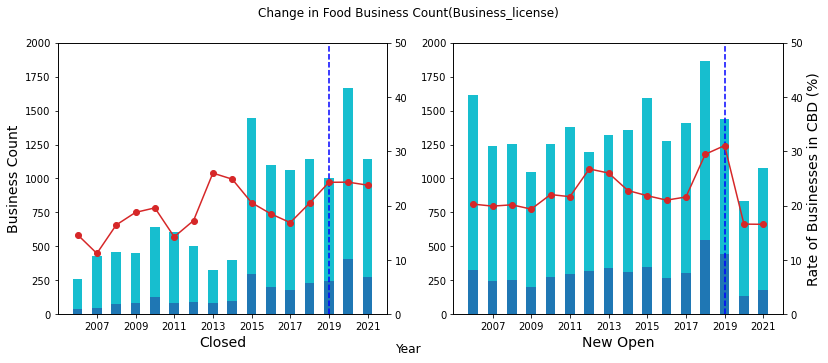

In [7]:
#use business license data
x = [i for i in range(2006,2022)]
y1_all = [len(food_license[food_license.close==str(y)]) for y in x]
y1_cbd = [sum(food_license[food_license.close==str(y)].is_cbd) for y in x]
y1_all.pop(6)
y1_all.insert(6, (y1_all[5]+y1_all[7])/2)
y1_cbd.pop(6)
y1_cbd.insert(6, (y1_cbd[5]+y1_cbd[7])/2)
y1 =[100*sum(food_license[food_license.close==str(y)].is_cbd)/len(food_license[food_license.close==str(y)])
        for y in x]
y2 = [100*sum(food_license[food_license.open==str(y)].is_cbd)/len(food_license[food_license.open==str(y)])
        for y in x]
fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(121)
ax_o = fig.add_subplot(122)
ax.bar(x,y1_all,color="tab:cyan", width= 0.5 )
ax.bar(x,y1_cbd,color="tab:blue", width= 0.5 )

ax.set_xlabel("Closed",fontsize=14)
ax.set_ylabel("Business Count",fontsize=14)
ax.set_ylim(0,2000)
ax2=ax.twinx()
ax2.plot(x,y1, color="tab:red",marker="o" )

ax2.set_ylim(0,50)
ax.set_xticks(x[1::2], minor=False)
ax_o.bar(x,[len(food_license[food_license.open==str(y)]) for y in x],color="tab:cyan", width= 0.5 )
ax_o.bar(x,[sum(food_license[food_license.open==str(y)].is_cbd) for y in x],color="tab:blue", width= 0.5 )
ax_o.set_xlabel("New Open",fontsize=14)
ax_o.set_ylim(0,2000)
ax2=ax_o.twinx()
ax2.plot(x,y2, color="tab:red",marker="o" )
ax2.set_ylabel("Rate of Businesses in CBD (%)",fontsize=14)
ax2.set_ylim(0,50)
ax_o.set_xticks(x[1::2], minor=False)
ax.vlines(2019, 0, 2000, linestyles='--', color='b')
ax_o.vlines(2019, 0, 2000, linestyles='--', color='b')

fig.suptitle(f'Change in Food Business Count(Business_license)')
fig.supxlabel('Year')
plt.savefig("../output/licenses.png")
plt.show()

## Run DID model

### With Yelp data

In [719]:
status_col =['close_%s'%(y) for y in years[1:]]+['open_%s'%(y) for y in years[1:]]
df_yelp =food[['tract','block', 'geoid','is_cbd','postal_code'] + status_col]
df_tract = df_yelp.groupby(['tract'])['close_2012',
 'close_2013','close_2014','close_2015','close_2016','close_2017','close_2018','close_2019','close_2020',
 'close_2021','open_2012','open_2013','open_2014','open_2015','open_2016','open_2017','open_2018','open_2019',
 'open_2020','open_2021'].apply(lambda x : x.astype(int).sum())
df_tract.reset_index(inplace=True)
df_tract = pd.wide_to_long(df_tract, ["close_", "open_"], i="tract", j="year")
df_tract.reset_index(inplace=True)

df_tract['is_cbd'] = df_tract.apply(lambda row: 1 if row.tract in cbd_census else 0,axis =1)
df_tract['post_covid'] = df_tract.apply(lambda x: 1 if x.year>=2020 else 0, axis=1)

#creating interaction variable
df_tract['DID'] = df_tract.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
df_tract['open_ln'] = np.log(df_tract.open_)
df_tract['close_ln'] = np.log(df_tract.close_)

#### New Open

In [738]:
# fit model
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['open_']
model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/yelp_open.png')
plt.close()
write_path = '../output/yelp_open.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:                  open_   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     120.7
Date:                Mon, 02 May 2022   Prob (F-statistic):           8.16e-75
Time:                        23:13:08   Log-Likelihood:                -8919.9
No. Observations:                3970   AIC:                         1.785e+04
Df Residuals:                    3966   BIC:                         1.787e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9787      0.028     35.042      0.0

In [737]:
# fit model with log(open_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['open_ln']>=0]
y_ln = df_tract['open_ln'][df_tract['open_ln']>=0]
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est = sm.OLS(y_ln, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/yelp_open_ln.png')
plt.close()
write_path = '../output/yelp_open_ln.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:                open_ln   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     158.0
Date:                Mon, 02 May 2022   Prob (F-statistic):           2.81e-92
Time:                        23:12:46   Log-Likelihood:                -2077.6
No. Observations:                2086   AIC:                             4163.
Df Residuals:                    2082   BIC:                             4186.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5033      0.016     31.224      0.0

#### Close

In [739]:
# fit model
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']]
y = df_tract['close_']
model = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/yelp_close.png')
plt.close()
write_path = '../output/yelp_close.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:                 close_   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     140.3
Date:                Mon, 02 May 2022   Prob (F-statistic):           2.18e-86
Time:                        23:13:55   Log-Likelihood:                -9225.4
No. Observations:                3970   AIC:                         1.846e+04
Df Residuals:                    3966   BIC:                         1.848e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8134      0.025     32.267      0.0

In [740]:
# fit model with log(close_count)
x = df_tract.loc[:,['is_cbd', 'post_covid','DID']][df_tract['close_ln']>=0]
y_ln = df_tract['close_ln'][df_tract['close_ln']>=0]
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est = sm.OLS(y_ln, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/yelp_close_ln.png')
plt.close()
write_path = '../output/yelp_close_ln.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:               close_ln   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 02 May 2022   Prob (F-statistic):           1.99e-94
Time:                        23:14:41   Log-Likelihood:                -2112.3
No. Observations:                2041   AIC:                             4233.
Df Residuals:                    2037   BIC:                             4255.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4533      0.017     26.911      0.0

### With licenses data

In [742]:
df_use = food_license[['censustrac' , 'open', 'close', 'is_cbd']]
df_cen = pd.DataFrame(df_use.censustrac.value_counts())
df_cen.reset_index(inplace=True)
df_cen.rename({"index":"census_track", "censustrac": "count"}, inplace=True, axis=1)
cen_trac = df_use.censustrac.unique()
df_use['close'][df_use.close=='3013'] = '2013'

#### New Open

In [743]:
c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].open.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","open":"open_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data = pd.concat(c_lst, ignore_index=True)

data['post_covid'] = data.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)
#creating interaction variable
data['DID'] = data.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data['open_ln'] = np.log(data.open_count)

census_dic = dict(data.census_track.value_counts())
for k in data['census_track'].unique():
    if census_dic[k] <= 20: #10
        data.drop(data[data['census_track'] == k].index, inplace = True)

In [744]:
# fit model 
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y = data['open_count']
model_ln = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/license_open.png')
plt.close()
write_path = '../output/license_open.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:             open_count   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 02 May 2022   Prob (F-statistic):           7.05e-68
Time:                        23:15:59   Log-Likelihood:                -17250.
No. Observations:                5096   AIC:                         3.451e+04
Df Residuals:                    5092   BIC:                         3.453e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1205      0.088     58.176      0.0

In [745]:
# fit model with log(open_count)
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data['open_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est = sm.OLS(y_ln, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/license_open_ln.png')
plt.close()
write_path = '../output/license_open_ln.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:                open_ln   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     78.01
Date:                Mon, 02 May 2022   Prob (F-statistic):           2.48e-49
Time:                        23:16:26   Log-Likelihood:                -6477.9
No. Observations:                5096   AIC:                         1.296e+04
Df Residuals:                    5092   BIC:                         1.299e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2673      0.013     94.568      0.0

#### Close

In [746]:
c_lst = []
for c in cen_trac:
    df = pd.DataFrame(df_use[df_use.censustrac==c].close.value_counts())
    df.reset_index(inplace=True)
    df.rename({"index":"year","close":"close_count"}, inplace=True, axis=1)
    df['census_track'] = c
    df['is_cbd'] = df_use[df_use.censustrac==c].is_cbd.max()
    
    c_lst.append(df)
data = pd.concat(c_lst, ignore_index=True)
data['post_covid'] = data.apply(lambda x: 1 if int(x.year)>=2020 else 0, axis=1)

#creating interaction variable
data['DID'] = data.apply( lambda x: 1 if (x['is_cbd']==1) and (x['post_covid']==1) else 0, axis=1)
# create log open count
data['close_ln'] = np.log(data.close_count)

census_dic = dict(data.census_track.value_counts())
for k in data['census_track'].unique():
    if census_dic[k] <= 5:
        data.drop(data[data['census_track'] == k].index, inplace = True)

In [747]:
# fit model 
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y = data['close_count']
model_ln = LinearRegression().fit(x, y)
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/license_close.png')
plt.close()
write_path = '../output/license_close.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:            close_count   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     20.32
Date:                Mon, 02 May 2022   Prob (F-statistic):           4.43e-13
Time:                        23:17:02   Log-Likelihood:                -14811.
No. Observations:                4588   AIC:                         2.963e+04
Df Residuals:                    4584   BIC:                         2.966e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7721      0.093     40.601      0.0

In [748]:
# fit model with log(close_count)
x = data.loc[:,['is_cbd', 'post_covid','DID']]
y_ln = data['close_ln']
model_ln = LinearRegression().fit(x, y_ln)
X2 = sm.add_constant(x)
est = sm.OLS(y_ln, X2)
est2 = est.fit()
model= est2.get_robustcov_results(cov_type='HC2', use_t=None)
print(model.summary())
#save output
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('../output/license_close_ln.png')
plt.close()
write_path = '../output/license_close_ln.csv'
with open(write_path, 'w') as f:
    f.write(model.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:               close_ln   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     26.50
Date:                Mon, 02 May 2022   Prob (F-statistic):           5.44e-17
Time:                        23:17:25   Log-Likelihood:                -5866.4
No. Observations:                4588   AIC:                         1.174e+04
Df Residuals:                    4584   BIC:                         1.177e+04
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8611      0.015     57.035      0.0